In [ ]:
# Access google drive and change directory to project folder
from google.colab import drive
drive.mount('/content/gdrive')

%cd /content/gdrive/MyDrive/DadepardazAfagh/TASK2/Deployment

# Install requirements if needed
# !pip install -r requirements.txt

In [ ]:
# Set some initial values

device = select_device('0')   # selecting CUDA device 0

plate_img_size = 640  # PLATE DETECTION MODEL training image size
plate_weight = 'plate.pt'      # path to PLATE DETECTION yolo model

char_img_size = 320   # OCR MODEL training image size
char_weight = 'character.pt'   # path to OCR yolo model

# Path to folder containing images for detection
images_path = 'test_imgs'

In [ ]:
import cv2
import torch
import torch.backends.cudnn as cudnn
from numpy import random
from models.experimental import attempt_load
from utils.general import check_img_size, non_max_suppression, scale_coords
from utils.plots import plot_one_box
from utils.torch_utils import select_device
from utils.datasets import letterbox
import numpy as np
import os


# Load plate model
plate_model = attempt_load(plate_weight, map_location=device)  # load FP32 model

# Load character model
char_model = attempt_load(char_weight, map_location=device)  # load FP32 model

# Run inference
if device.type != 'cpu':
  plate_imgsz = check_img_size(plate_img_size, s=int(plate_model.stride.max()))  # check img_size
  plate_model(torch.zeros(1, 3, plate_imgsz, plate_imgsz).to(device).type_as(next(plate_model.parameters())))  # run once

  char_imgsz = check_img_size(char_img_size, s=int(char_model.stride.max()))  # check img_size
  char_model(torch.zeros(1, 3, char_imgsz, char_imgsz).to(device).type_as(next(char_model.parameters())))  # run once

# Lookup table to translate model classes to desired values
character_lookup = {
    'Alef': '-ALEF-', 'Ayn': '-TA-', 'B': '-B-', 'D': '-YE-', 'Gh': '-GH-',
    'J': '-J-', 'Janbaz': '-SAD-', 'L': '-L-', 'M': '-M-', 'N': '-N-',
    'Sad': '-SIN-', 'Sin': '-D-', 'Ta': '-TAXI-', 'Te': '-♿-', 'V': '-V-',
    'eight': '8', 'five': '5', 'four': '4', 'i': '-AYN-', 'nine': '9',
    'one': '1', 'seven': '7', 'six': '6', 'three': '3', 'two': '2', 'zero': '0'
}


def detect(image, model, img_size, conf_thres = 0.25, iou_thres = 0.45):

  """
  A function to perform object detection on images using YOLO models

  This function is deeply inspired by the original YOLOv7 project.

  Parameters:
  image (ndarray): The OpenCV BGR image.
  model (Model): The YOLO model.
  img_size (int): Model training image size.
  conf_thres (float): Minimum confidence threshold to detect an object.
  iou_thres (float): intersection over union threshold for detection boxes.

  Returns:
  list: A list of results with the following structure: [([x1, y1, x2, y2], class, confidence), ...]

  """

  stride = int(model.stride.max())  # model stride
  imgsz = check_img_size(img_size, s=stride)  # check img_size

  # Padded resize
  img = letterbox(image, img_size, stride=stride)[0]
  # Convert
  img = img[:, :, ::-1].transpose(2, 0, 1)  # BGR to RGB, to 3x416x416
  img = np.ascontiguousarray(img)

  # Get class names
  names = model.module.names if hasattr(model, 'module') else model.names

  old_img_w = old_img_h = imgsz
  old_img_b = 1

  img = torch.from_numpy(img).to(device)
  # img = img.half() if half else img.float()  # uint8 to fp16/32
  img = img.float()
  img /= 255.0  # 0 - 255 to 0.0 - 1.0
  if img.ndimension() == 3:
    img = img.unsqueeze(0)

  if device.type != 'cpu' and (old_img_b != img.shape[0] or old_img_h != img.shape[2] or old_img_w != img.shape[3]):
    old_img_b = img.shape[0]
    old_img_h = img.shape[2]
    old_img_w = img.shape[3]

  # Inference
  pred = model(img)[0]

  # Apply NMS
  pred = non_max_suppression(pred, conf_thres, iou_thres)#, classes=opt.classes, agnostic=opt.agnostic_nms)

  all_dets = list()
  # Process detections
  for det in pred:  # detections per image
    if len(det):
      # Rescale boxes from img_size to original image size
      det[:, :4] = scale_coords(img.shape[2:], det[:, :4], image.shape).round()
      # Process results
      for *xyxy, conf, cls in reversed(det):
        # Add bbox to list of results
        all_dets.append((xyxy, names[int(cls)], float(conf)))

  return all_dets


# Output directory
output_path = os.path.join(images_path, 'output')

# Creating output directory if it does not exist
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Go trough all the input images
for image_name in os.listdir(images_path):

  # Path to one image
  image_path = os.path.join(images_path, image_name)

  # Make sure the path is a file
  if not os.path.isfile(image_path):
    continue

  # Read the image
  image = cv2.imread(image_path)  # BGR

  # Make sure the image is read properly
  if image is None:
    continue

  # Detect all the license plates in the image
  all_plates = detect(image, plate_model, plate_img_size)

  # Go through all the license plates
  for a_plate in all_plates:

    # Extract each license plate's information
    x1 = int(a_plate[0][0])
    y1 = int(a_plate[0][1])
    x2 = int(a_plate[0][2])
    y2 = int(a_plate[0][3])
    label = a_plate[1]
    conf = a_plate[2]

    # Expand the Bbox of the current license plate to have a better image for OCR
    w = int((x2 - x1) * 0.1 / 2)  # calculate width expantion
    h = int((y2 - y1) * 0.1 / 2)  # calculate hight expantion
    Y1 = max(y1 - h, 0)   # Calculate new y1
    X1 = max(x1 - w, 0)   # Calculate new x1
    Y2 = min(y2 + h, image.shape[0])   # Calculate new y2
    X2 = min(x2 + w, image.shape[1])   # Calculate new x2

    # Read the license plate
    plate_img = image[Y1:Y2, X1:X2]
    all_chars = detect(plate_img, char_model, char_img_size, conf_thres=0.2, iou_thres=0.5)

    # Process and sort the results
    all_chars = [(int(a[0]), b, c) for a, b, c in all_chars]
    all_chars = sorted(all_chars, key=lambda x: x[0])

    # It is a good practice to group all the detections that are close to
    # each other and select the one with higher confidence
    dist_thres = 0.06   # minimum distane threshold to group Bboxes
    results = list()
    while all_chars:
      org = all_chars[0][0]
      tmp = list()
      for char in all_chars:
        if abs(char[0] - org) < int((X2 - X1) * dist_thres):
          tmp.append(char)
      tmp = sorted(tmp, key=lambda x: x[-1], reverse=True)
      results.append(tmp[0][1])
      for item in tmp:
        all_chars.remove(item)

    # Translate the detection classes to plate characters
    label = str()
    for ch in results:
      label += character_lookup[ch]

    # Draw the results on the image
    plot_one_box(a_plate[0], image, label=label, color=(0, 0, 255), line_thickness=1)

  # Write output
  image_output = os.path.join(output_path, 'OUT_'+image_name)
  cv2.imwrite(image_output, image)
  print(image_output)


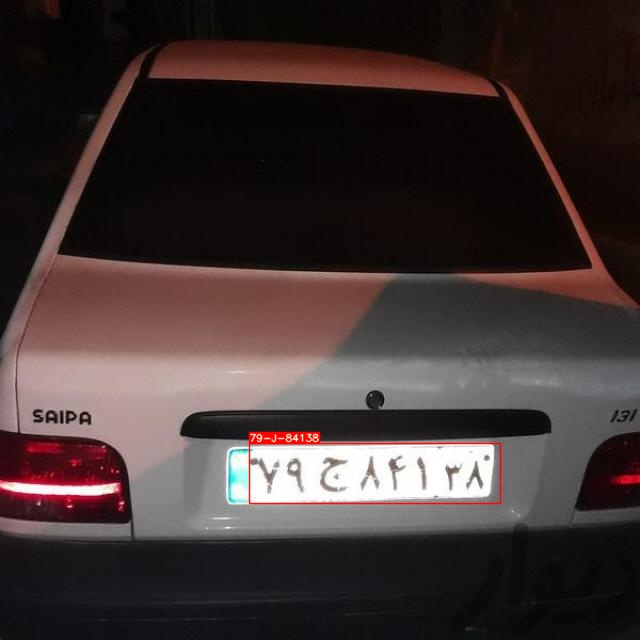

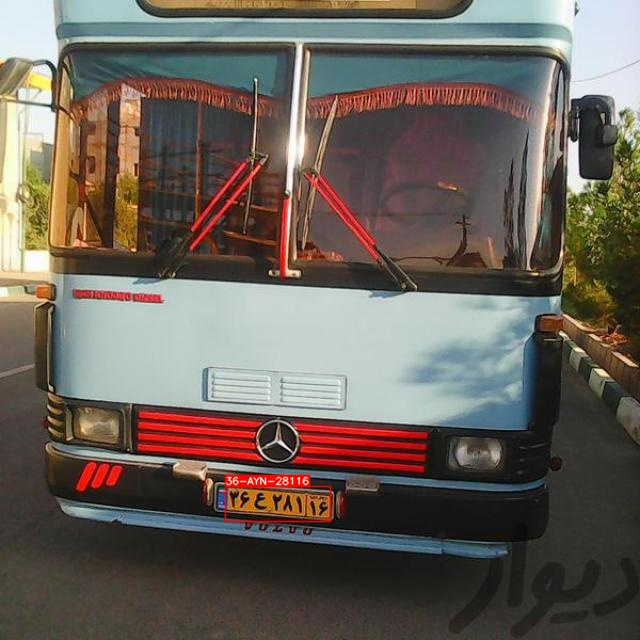

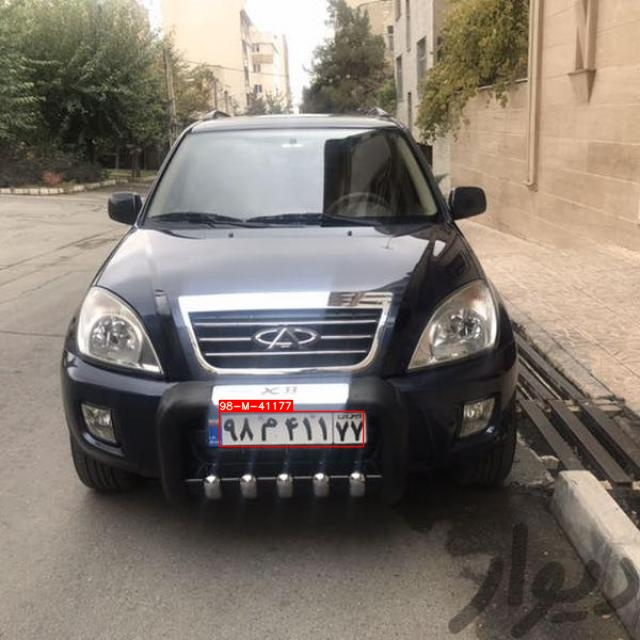

In [27]:
# Check out some of the results
from IPython.display import Image

display(Image("test_imgs/output/OUT_002323_jpg.rf.6acbfe64436448d807d5db74dcc86a80.jpg", width=640, height=640))
display(Image("test_imgs/output/OUT_002305_jpg.rf.be6cb01467bfaaad224391380a23e840.jpg", width=640, height=640))
display(Image("test_imgs/output/OUT_002384_jpg.rf.3d75fab6b237f511ff69e59c8258966f.jpg", width=640, height=640))